## Notebook for viewing and testing inclusive plots

### Plots included
### - Closure Test (from 2DAlphabet output)
### -  ttbar mass with signals
### - Transfer function
### - Closure Test from processor --- work in progress
### - QCD Closure Test from processor --- work in progress

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
from coffea import util
import itertools
import os, sys
import glob
import copy
from scipy.optimize import curve_fit
import uproot
import json

sys.path.append('../python/')
import functions

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Initialize

In [34]:

IOV = '2016all'


# scale factors and luminosity

lumi = functions.lumi
rsgluon_xs = functions.rsgluon_xs



# initialize

functions.makeSaveDirectories()

        
# binsize = 1/np.diff(hbkg.axes['ttbarmass'].edges)[0]
binsize = 10

blind = True
lumifactor = 0.1 if blind else 1.0

label_map = functions.getLabelMap()
label_to_int = {label: i for i, label in label_map.items()}

signal_cats = [ i for label, i in label_to_int.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int.items() if 'at' in label]


lines_dict = {'solid': 'solid',
 'dotted': (0, (1, 1)),
 'dashed': (0, (5, 5)),
 'dashdot': 'dashdot',
 'loosely dotted': (0, (1, 10)),
 'densely dotted': (0, (1, 1)),
 'long dash with offset': (5, (10, 3)),
 'loosely dashed': (0, (5, 10)),
 'densely dashed': (0, (5, 1)),
 'loosely dashdotted': (0, (3, 10, 1, 10)),
 'dashdotted': (0, (3, 5, 1, 5)),
 'densely dashdotted': (0, (3, 1, 1, 1)),
 'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
 'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
 'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1))}

lines = list(lines_dict.values())


# categories and systematics labels

cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

systematics = ['nominal', 'jes', 'jer', 'pileup', 'pdf', 'q2', 'btag', 'prefiring']
syst_labels = ['nominal']
for s in systematics:
    if not 'nominal' in s:
        syst_labels.append(s+'Down')
        syst_labels.append(s+'Up')

        

## functions

In [17]:
# def getUncertainy(hbkg, hUnc):
    
#     axes_systematics = hUnc.axes['systematic']
    
#     nomvals = hbkg.values()

#     for syst in axes_systematics:

#         if 'Up' in syst:

#             upvals = (1 + np.abs(nomvals - hUnc[{'systematic':syst}].values())/nomvals)

#         elif 'Down' in syst:

#             downvals = (1 - np.abs(nomvals - hUnc[{'systematic':syst}].values())/nomvals)
            
#     return hbkg*upvals, hbkg*downvals



def getUncertainy(hbkg, hUnc):
    
    axes_systematics = hUnc.axes['systematic']
    
    nomvals = hUnc[{'systematic':'nominal'}].values()
    upvals = np.ones_like(nomvals)
    downvals = np.ones_like(nomvals)


    for syst in axes_systematics:

        if 'Up' in syst:
            


            upvals *= hUnc[{'systematic':syst}].values()/nomvals

        elif 'Down' in syst:
            
            downvals *= hUnc[{'systematic':syst}].values()/nomvals
        
#     upvals = upvals * nomvals
#     downvals = downvals * nomvals
    downvals = np.array([*downvals[:-10], np.sum(downvals[-10:-5])/5.])
    upvals = np.array([*upvals[:-10], np.sum(upvals[-10:-5])/5.])
    
    return upvals, downvals



# transfer function
def rpf(x, y, p):
    
    scale = ( p[0] + p[1]*x + p[2]*x*x + p[3]*x*x*x ) * ( 1 + p[4]*y ) 

    return scale
    
    
# transfer function
def rpf_0x1(x, y, p):
    
    # @0+@1*y
    
    scale = ( p[0] + p[1]*y )

    return np.abs(scale)   
    
    
    
    


In [ ]:
# f_cen0b.keys()

## Closure Test
### using output root file (`all_plots.root`) from 2DAlphabet
- root file copied from lxplus in `ttbar-{signal}/plots_fit_b/all_plots.root` to `plots/` directory
- saved as `all_plots_2016.root`, `all_plots_2017.root`, `all_plots_2018.root` for corresponding years

### ttbarmass

saving  images/pdf/ttbarmass/2018/ttbarmass_inclusive_root.pdf
saving  images/png/ttbarmass/2018/ttbarmass_inclusive_root.png


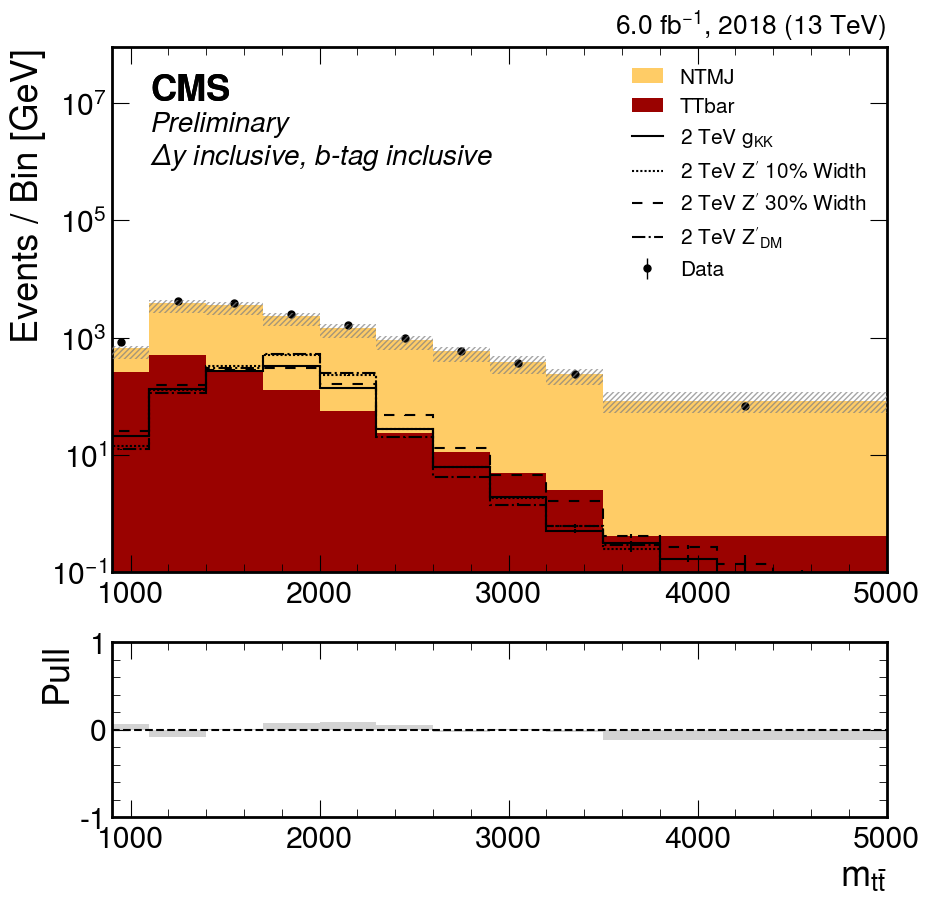

In [32]:
IOV = '2018'
tag = ''

ttbar_str = IOV.replace('20','').replace('all','')

f_cen0b = uproot.open(f'all_plots_{IOV.replace("all","")}_cen0b.root')
f_cen1b = uproot.open(f'all_plots_{IOV.replace("all","")}_cen1b.root')
f_cen2b = uproot.open(f'all_plots_{IOV.replace("all","")}_cen2b.root')
f_fwd0b = uproot.open(f'all_plots_{IOV.replace("all","")}_fwd0b.root')
f_fwd1b = uproot.open(f'all_plots_{IOV.replace("all","")}_fwd1b.root')
f_fwd2b = uproot.open(f'all_plots_{IOV.replace("all","")}_fwd2b.root')

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

hbkg0   = [
    f_cen0b['TotalBkg_cen0bPass_postfit_projy0;1'],
    f_cen0b['TotalBkg_cen0bPass_postfit_projy1;1'],
    f_cen0b['TotalBkg_cen0bPass_postfit_projy2;1'],
    f_cen1b['TotalBkg_cen1bPass_postfit_projy0;1'],
    f_cen1b['TotalBkg_cen1bPass_postfit_projy1;1'],
    f_cen1b['TotalBkg_cen1bPass_postfit_projy2;1'],
    f_cen2b['TotalBkg_cen2bPass_postfit_projy0;1'],
    f_cen2b['TotalBkg_cen2bPass_postfit_projy1;1'],
    f_cen2b['TotalBkg_cen2bPass_postfit_projy2;1'],
    f_fwd0b['TotalBkg_fwd0bPass_postfit_projy0;1'],
    f_fwd0b['TotalBkg_fwd0bPass_postfit_projy1;1'],
    f_fwd0b['TotalBkg_fwd0bPass_postfit_projy2;1'],
    f_fwd1b['TotalBkg_fwd1bPass_postfit_projy0;1'],
    f_fwd1b['TotalBkg_fwd1bPass_postfit_projy1;1'],
    f_fwd1b['TotalBkg_fwd1bPass_postfit_projy2;1'],
    f_fwd2b['TotalBkg_fwd2bPass_postfit_projy0;1'],
    f_fwd2b['TotalBkg_fwd2bPass_postfit_projy1;1'],
    f_fwd2b['TotalBkg_fwd2bPass_postfit_projy2;1']

]

httbar0   = [
    f_cen0b[ttbar_str+'_TTbar_cen0bPass_postfit_projy0;1'],
    f_cen0b[ttbar_str+'_TTbar_cen0bPass_postfit_projy1;1'],
    f_cen0b[ttbar_str+'_TTbar_cen0bPass_postfit_projy2;1'],
    f_cen1b[ttbar_str+'_TTbar_cen1bPass_postfit_projy0;1'],
    f_cen1b[ttbar_str+'_TTbar_cen1bPass_postfit_projy1;1'],
    f_cen1b[ttbar_str+'_TTbar_cen1bPass_postfit_projy2;1'],
    f_cen2b[ttbar_str+'_TTbar_cen2bPass_postfit_projy0;1'],
    f_cen2b[ttbar_str+'_TTbar_cen2bPass_postfit_projy1;1'],
    f_cen2b[ttbar_str+'_TTbar_cen2bPass_postfit_projy2;1'],
    f_fwd0b[ttbar_str+'_TTbar_fwd0bPass_postfit_projy0;1'],
    f_fwd0b[ttbar_str+'_TTbar_fwd0bPass_postfit_projy1;1'],
    f_fwd0b[ttbar_str+'_TTbar_fwd0bPass_postfit_projy2;1'],
    f_fwd1b[ttbar_str+'_TTbar_fwd1bPass_postfit_projy0;1'],
    f_fwd1b[ttbar_str+'_TTbar_fwd1bPass_postfit_projy1;1'],
    f_fwd1b[ttbar_str+'_TTbar_fwd1bPass_postfit_projy2;1'],
    f_fwd2b[ttbar_str+'_TTbar_fwd2bPass_postfit_projy0;1'],
    f_fwd2b[ttbar_str+'_TTbar_fwd2bPass_postfit_projy1;1'],
    f_fwd2b[ttbar_str+'_TTbar_fwd2bPass_postfit_projy2;1']

]


hdata0   = [
    f_cen0b['data_obs_cen0bPass_postfit_projy0;1'],
    f_cen0b['data_obs_cen0bPass_postfit_projy1;1'],
    f_cen0b['data_obs_cen0bPass_postfit_projy2;1'],
    f_cen1b['data_obs_cen1bPass_postfit_projy0;1'],
    f_cen1b['data_obs_cen1bPass_postfit_projy1;1'],
    f_cen1b['data_obs_cen1bPass_postfit_projy2;1'],
    f_cen2b['data_obs_cen2bPass_postfit_projy0;1'],
    f_cen2b['data_obs_cen2bPass_postfit_projy1;1'],
    f_cen2b['data_obs_cen2bPass_postfit_projy2;1'],
    f_fwd0b['data_obs_fwd0bPass_postfit_projy0;1'],
    f_fwd0b['data_obs_fwd0bPass_postfit_projy1;1'],
    f_fwd0b['data_obs_fwd0bPass_postfit_projy2;1'],
    f_fwd1b['data_obs_fwd1bPass_postfit_projy0;1'],
    f_fwd1b['data_obs_fwd1bPass_postfit_projy1;1'],
    f_fwd1b['data_obs_fwd1bPass_postfit_projy2;1'],
    f_fwd2b['data_obs_fwd2bPass_postfit_projy0;1'],
    f_fwd2b['data_obs_fwd2bPass_postfit_projy1;1'],
    f_fwd2b['data_obs_fwd2bPass_postfit_projy2;1']

]


hbkg = hbkg0[0].to_hist() + hbkg0[1].to_hist() + hbkg0[2].to_hist() +  \
       hbkg0[3].to_hist() + hbkg0[4].to_hist() + hbkg0[5].to_hist() + \
       hbkg0[9].to_hist() + hbkg0[10].to_hist() + hbkg0[11].to_hist() + \
       hbkg0[12].to_hist() + hbkg0[13].to_hist() + hbkg0[14].to_hist() + \
       hbkg0[15].to_hist() + hbkg0[16].to_hist() + hbkg0[17].to_hist()

#        hbk/g0[6].to_hist() + hbkg0[7].to_hist() + hbkg0[8].to_hist() + \
# 

httbar = httbar0[0].to_hist()  + httbar0[1].to_hist()  + httbar0[2].to_hist() +  \
         httbar0[3].to_hist()  + httbar0[4].to_hist()  + httbar0[5].to_hist() + \
         httbar0[9].to_hist()  + httbar0[10].to_hist() + httbar0[11].to_hist() + \
         httbar0[12].to_hist() + httbar0[13].to_hist() + httbar0[14].to_hist() + \
         httbar0[15].to_hist() + httbar0[16].to_hist() + httbar0[17].to_hist()


#          httbar0[6].to_hist()  + httbar0[7].to_hist()  + httbar0[8].to_hist() + \

hdata  = hdata0[0].to_hist()  + hdata0[1].to_hist()  + hdata0[2].to_hist() +  \
         hdata0[3].to_hist()  + hdata0[4].to_hist()  + hdata0[5].to_hist() + \
         hdata0[9].to_hist()  + hdata0[10].to_hist() + hdata0[11].to_hist() + \
         hdata0[12].to_hist() + hdata0[13].to_hist() + hdata0[14].to_hist() + \
         hdata0[15].to_hist() + hdata0[16].to_hist() + hdata0[17].to_hist()

#          hdata0[6].to_hist()  + hdata0[7].to_hist()  + hdata0[8].to_hist() + \


hgkk = functions.getHist2('ttbarmass', 'RSGluon2000', IOV,
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
                        )

hz10 = functions.getHist2('ttbarmass', 'ZPrime2000_10', IOV,
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
                        )

hz30 = functions.getHist2('ttbarmass', 'ZPrime2000_30', IOV,
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
                        )

hzDM = functions.getHist2('ttbarmass', 'ZPrime2000_DM', IOV,
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
                        )


hUnc = functions.getHist2('ttbarmass', 'TTbar', IOV,
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats},
                         tag=tag
                        )




if IOV == '2016':
    
    IOV = '2016all'
    
    lumifactor = 1.0
    
    hdata2 = functions.getHist2('ttbarmass', 'JetHT', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats, 'systematic':'nominal'},
                         tag=''
                        )
    
    
else:
    
    lumifactor = 0.1
    
    hdata2 = functions.getHist2('ttbarmass', 'JetHT', IOV,
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats, 'systematic':'nominal'},
                         tag='_blind'
                        )


hUp, hDn = getUncertainy(hbkg, hUnc)

pull_plot =  (hdata + -1*hbkg)/(hUp[1:]*hbkg.values() - hDn[1:]*hbkg.values())


# hUp = hUp * lumifactor
# hDn = hDn * lumifactor

hbkg = hbkg * lumifactor
httbar = httbar * lumifactor
hgkk = hgkk * lumifactor
hz10 = hz10 * lumifactor
hz30 = hz30 * lumifactor
hzDM = hzDM * lumifactor








# errors 
errs = np.sqrt(hbkg.variances())

height = hbkg.values() * (hUp[1:] - 1)
bottom = hbkg.values() * hDn[1:]
edges  = hbkg.axes['xaxis'].edges
# edges  = hUnc[{'systematic':'nominal'}].axes['ttbarmass'].edges




text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'
# text += '\n' + r'$0 < m_{t} < 125$ GeV'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

# hep.histplot(hdata, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hdata2[900j:3500j]/2, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hdata2[3500j:5000j][::5j]/10, histtype='errorbar', color='black', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='#ffcc66', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)
hep.histplot(hgkk, histtype='step', color='black', linestyle=lines[0], label=r'$g_{KK}$ 2 TeV', ax=ax1)
hep.histplot(hz10, histtype='step', color='black', linestyle=lines[1], label=r"$Z'$ 10% Width 2 TeV", ax=ax1)
hep.histplot(hz30, histtype='step', color='black', linestyle=lines[2], label=r"$Z'$ 30% Width 2 TeV", ax=ax1)
hep.histplot(hzDM, histtype='step', color='black', linestyle=lines[3], label=r"$Z'_{DM}$ 2 TeV", ax=ax1)





ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')



hep.histplot(pull_plot, ax=ax2, histtype='fill', color='lightgray')
ax2.set_ylim(-1,1)
ax2.axhline(0, color='black', ls='--')
ax2.set_ylabel('Pull')


ax1.legend(['NTMJ', 'TTbar', r'2 TeV $g_{KK}$', r"2 TeV $Z'$ 10% Width", r"2 TeV $Z'$ 30% Width", r"2 TeV $Z'_{DM}$", 'Data'], fontsize=15)
ax1.set_ylabel(f'Events / Bin [GeV]'.replace('j',''))
ax2.set_xlabel(r'$m_{t\bar{t}}$')

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 0.9*1e8)
ax1.set_xlim(900,5000)
ax2.set_xlim(900,5000)
ax1.set_xlabel('')


savefilename = f'images/pdf/ttbarmass/{IOV}/ttbarmass_inclusive_root.pdf'

plt.savefig(savefilename)
plt.savefig(savefilename.replace('pdf', 'png'))


print('saving ', savefilename)
print('saving ', savefilename.replace('pdf', 'png'))




[1.41471372 1.40372274 1.40762988 1.42484984 1.44500984 1.45961283
 1.52048425 1.51375645 1.52605687 1.5534439  1.77016495]
[1.42962826 1.40904389 1.41097127 1.42813321 1.44682968 1.454827
 1.49144423 1.50866287 1.56424402 1.61388282 1.77398965]
[1.43212705 1.41408462 1.42425275 1.42558507 1.44655379 1.45767518
 1.49937673 1.53840026 1.64965971 1.54147734 1.79447106]
saving  images/pdf/ttbarmass/all/ttbarmass_inclusive_root.pdf
saving  images/png/ttbarmass/all/ttbarmass_inclusive_root.png


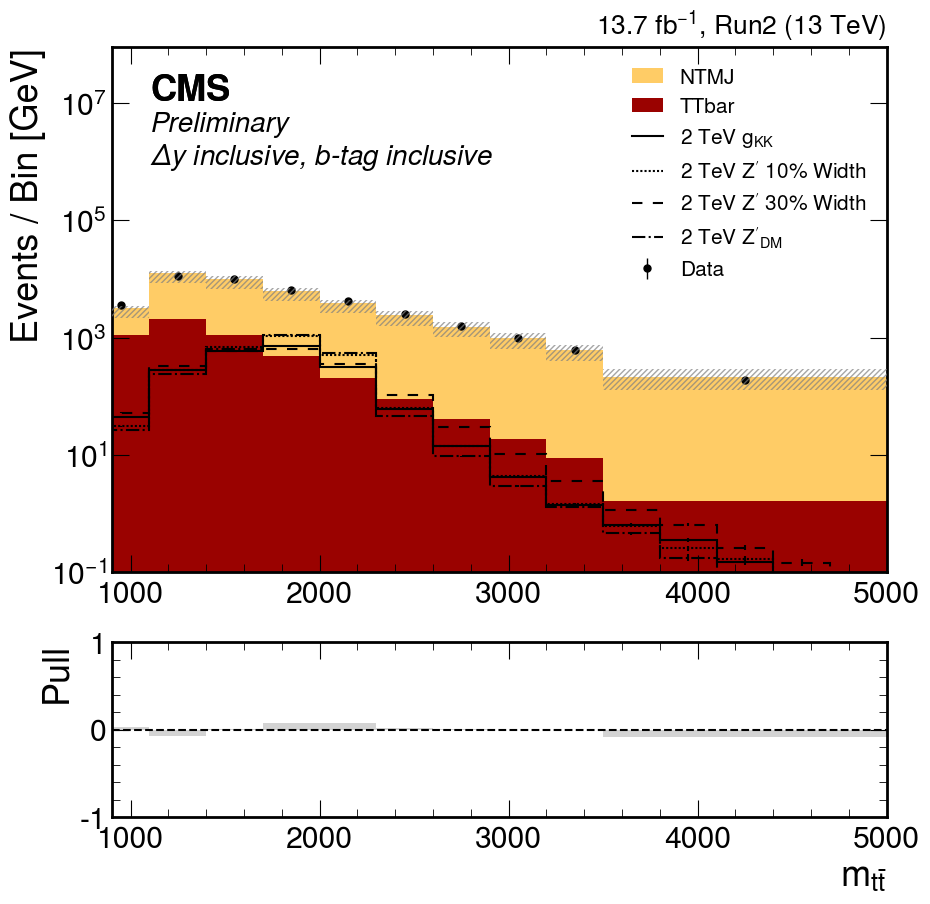

In [29]:
IOV = 'all'
tag = ''

ttbar_str = IOV.replace('20','').replace('all','')

f_cen0b_2016 = uproot.open(f'all_plots_2016_cen0b.root')
f_cen1b_2016 = uproot.open(f'all_plots_2016_cen1b.root')
f_cen2b_2016 = uproot.open(f'all_plots_2016_cen2b.root')
f_fwd0b_2016 = uproot.open(f'all_plots_2016_fwd0b.root')
f_fwd1b_2016 = uproot.open(f'all_plots_2016_fwd1b.root')
f_fwd2b_2016 = uproot.open(f'all_plots_2016_fwd2b.root')

f_cen0b_2017 = uproot.open(f'all_plots_2017_cen0b.root')
f_cen1b_2017 = uproot.open(f'all_plots_2017_cen1b.root')
f_cen2b_2017 = uproot.open(f'all_plots_2017_cen2b.root')
f_fwd0b_2017 = uproot.open(f'all_plots_2017_fwd0b.root')
f_fwd1b_2017 = uproot.open(f'all_plots_2017_fwd1b.root')
f_fwd2b_2017 = uproot.open(f'all_plots_2017_fwd2b.root')


f_cen0b_2018 = uproot.open(f'all_plots_2018_cen0b.root')
f_cen1b_2018 = uproot.open(f'all_plots_2018_cen1b.root')
f_cen2b_2018 = uproot.open(f'all_plots_2018_cen2b.root')
f_fwd0b_2018 = uproot.open(f'all_plots_2018_fwd0b.root')
f_fwd1b_2018 = uproot.open(f'all_plots_2018_fwd1b.root')
f_fwd2b_2018 = uproot.open(f'all_plots_2018_fwd2b.root')


fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

hbkg0   = [
    f_cen0b_2016['TotalBkg_cen0bPass_postfit_projy0;1'],
    f_cen0b_2016['TotalBkg_cen0bPass_postfit_projy1;1'],
    f_cen0b_2016['TotalBkg_cen0bPass_postfit_projy2;1'],
    f_cen1b_2016['TotalBkg_cen1bPass_postfit_projy0;1'],
    f_cen1b_2016['TotalBkg_cen1bPass_postfit_projy1;1'],
    f_cen1b_2016['TotalBkg_cen1bPass_postfit_projy2;1'],
    f_cen2b_2016['TotalBkg_cen2bPass_postfit_projy0;1'],
    f_cen2b_2016['TotalBkg_cen2bPass_postfit_projy1;1'],
    f_cen2b_2016['TotalBkg_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2016['TotalBkg_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2016['TotalBkg_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2016['TotalBkg_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2016['TotalBkg_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2016['TotalBkg_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2016['TotalBkg_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2016['TotalBkg_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2016['TotalBkg_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2016['TotalBkg_fwd2bPass_postfit_projy2;1'],
    
    f_cen0b_2017['TotalBkg_cen0bPass_postfit_projy0;1'],
    f_cen0b_2017['TotalBkg_cen0bPass_postfit_projy1;1'],
    f_cen0b_2017['TotalBkg_cen0bPass_postfit_projy2;1'],
    f_cen1b_2017['TotalBkg_cen1bPass_postfit_projy0;1'],
    f_cen1b_2017['TotalBkg_cen1bPass_postfit_projy1;1'],
    f_cen1b_2017['TotalBkg_cen1bPass_postfit_projy2;1'],
    f_cen2b_2017['TotalBkg_cen2bPass_postfit_projy0;1'],
    f_cen2b_2017['TotalBkg_cen2bPass_postfit_projy1;1'],
    f_cen2b_2017['TotalBkg_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2017['TotalBkg_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2017['TotalBkg_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2017['TotalBkg_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2017['TotalBkg_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2017['TotalBkg_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2017['TotalBkg_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2017['TotalBkg_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2017['TotalBkg_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2017['TotalBkg_fwd2bPass_postfit_projy2;1'],
    
    f_cen0b_2018['TotalBkg_cen0bPass_postfit_projy0;1'],
    f_cen0b_2018['TotalBkg_cen0bPass_postfit_projy1;1'],
    f_cen0b_2018['TotalBkg_cen0bPass_postfit_projy2;1'],
    f_cen1b_2018['TotalBkg_cen1bPass_postfit_projy0;1'],
    f_cen1b_2018['TotalBkg_cen1bPass_postfit_projy1;1'],
    f_cen1b_2018['TotalBkg_cen1bPass_postfit_projy2;1'],
    f_cen2b_2018['TotalBkg_cen2bPass_postfit_projy0;1'],
    f_cen2b_2018['TotalBkg_cen2bPass_postfit_projy1;1'],
    f_cen2b_2018['TotalBkg_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2018['TotalBkg_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2018['TotalBkg_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2018['TotalBkg_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2018['TotalBkg_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2018['TotalBkg_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2018['TotalBkg_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2018['TotalBkg_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2018['TotalBkg_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2018['TotalBkg_fwd2bPass_postfit_projy2;1']

]

httbar0   = [
    f_cen0b_2016['16_TTbar_cen0bPass_postfit_projy0;1'],
    f_cen0b_2016['16_TTbar_cen0bPass_postfit_projy1;1'],
    f_cen0b_2016['16_TTbar_cen0bPass_postfit_projy2;1'],
    f_cen1b_2016['16_TTbar_cen1bPass_postfit_projy0;1'],
    f_cen1b_2016['16_TTbar_cen1bPass_postfit_projy1;1'],
    f_cen1b_2016['16_TTbar_cen1bPass_postfit_projy2;1'],
    f_cen2b_2016['16_TTbar_cen2bPass_postfit_projy0;1'],
    f_cen2b_2016['16_TTbar_cen2bPass_postfit_projy1;1'],
    f_cen2b_2016['16_TTbar_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2016['16_TTbar_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2016['16_TTbar_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2016['16_TTbar_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2016['16_TTbar_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2016['16_TTbar_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2016['16_TTbar_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2016['16_TTbar_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2016['16_TTbar_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2016['16_TTbar_fwd2bPass_postfit_projy2;1'],
    
    f_cen0b_2017['17_TTbar_cen0bPass_postfit_projy0;1'],
    f_cen0b_2017['17_TTbar_cen0bPass_postfit_projy1;1'],
    f_cen0b_2017['17_TTbar_cen0bPass_postfit_projy2;1'],
    f_cen1b_2017['17_TTbar_cen1bPass_postfit_projy0;1'],
    f_cen1b_2017['17_TTbar_cen1bPass_postfit_projy1;1'],
    f_cen1b_2017['17_TTbar_cen1bPass_postfit_projy2;1'],
    f_cen2b_2017['17_TTbar_cen2bPass_postfit_projy0;1'],
    f_cen2b_2017['17_TTbar_cen2bPass_postfit_projy1;1'],
    f_cen2b_2017['17_TTbar_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2017['17_TTbar_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2017['17_TTbar_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2017['17_TTbar_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2017['17_TTbar_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2017['17_TTbar_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2017['17_TTbar_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2017['17_TTbar_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2017['17_TTbar_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2017['17_TTbar_fwd2bPass_postfit_projy2;1'],
    
    f_cen0b_2018['18_TTbar_cen0bPass_postfit_projy0;1'],
    f_cen0b_2018['18_TTbar_cen0bPass_postfit_projy1;1'],
    f_cen0b_2018['18_TTbar_cen0bPass_postfit_projy2;1'],
    f_cen1b_2018['18_TTbar_cen1bPass_postfit_projy0;1'],
    f_cen1b_2018['18_TTbar_cen1bPass_postfit_projy1;1'],
    f_cen1b_2018['18_TTbar_cen1bPass_postfit_projy2;1'],
    f_cen2b_2018['18_TTbar_cen2bPass_postfit_projy0;1'],
    f_cen2b_2018['18_TTbar_cen2bPass_postfit_projy1;1'],
    f_cen2b_2018['18_TTbar_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2018['18_TTbar_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2018['18_TTbar_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2018['18_TTbar_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2018['18_TTbar_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2018['18_TTbar_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2018['18_TTbar_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2018['18_TTbar_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2018['18_TTbar_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2018['18_TTbar_fwd2bPass_postfit_projy2;1'],
    
    

]


hdata0   = [
    f_cen0b_2016['data_obs_cen0bPass_postfit_projy0;1'],
    f_cen0b_2016['data_obs_cen0bPass_postfit_projy1;1'],
    f_cen0b_2016['data_obs_cen0bPass_postfit_projy2;1'],
    f_cen1b_2016['data_obs_cen1bPass_postfit_projy0;1'],
    f_cen1b_2016['data_obs_cen1bPass_postfit_projy1;1'],
    f_cen1b_2016['data_obs_cen1bPass_postfit_projy2;1'],
    f_cen2b_2016['data_obs_cen2bPass_postfit_projy0;1'],
    f_cen2b_2016['data_obs_cen2bPass_postfit_projy1;1'],
    f_cen2b_2016['data_obs_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2016['data_obs_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2016['data_obs_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2016['data_obs_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2016['data_obs_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2016['data_obs_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2016['data_obs_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2016['data_obs_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2016['data_obs_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2016['data_obs_fwd2bPass_postfit_projy2;1'],
    
    f_cen0b_2017['data_obs_cen0bPass_postfit_projy0;1'],
    f_cen0b_2017['data_obs_cen0bPass_postfit_projy1;1'],
    f_cen0b_2017['data_obs_cen0bPass_postfit_projy2;1'],
    f_cen1b_2017['data_obs_cen1bPass_postfit_projy0;1'],
    f_cen1b_2017['data_obs_cen1bPass_postfit_projy1;1'],
    f_cen1b_2017['data_obs_cen1bPass_postfit_projy2;1'],
    f_cen2b_2017['data_obs_cen2bPass_postfit_projy0;1'],
    f_cen2b_2017['data_obs_cen2bPass_postfit_projy1;1'],
    f_cen2b_2017['data_obs_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2017['data_obs_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2017['data_obs_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2017['data_obs_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2017['data_obs_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2017['data_obs_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2017['data_obs_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2017['data_obs_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2017['data_obs_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2017['data_obs_fwd2bPass_postfit_projy2;1'],
    
    f_cen0b_2018['data_obs_cen0bPass_postfit_projy0;1'],
    f_cen0b_2018['data_obs_cen0bPass_postfit_projy1;1'],
    f_cen0b_2018['data_obs_cen0bPass_postfit_projy2;1'],
    f_cen1b_2018['data_obs_cen1bPass_postfit_projy0;1'],
    f_cen1b_2018['data_obs_cen1bPass_postfit_projy1;1'],
    f_cen1b_2018['data_obs_cen1bPass_postfit_projy2;1'],
    f_cen2b_2018['data_obs_cen2bPass_postfit_projy0;1'],
    f_cen2b_2018['data_obs_cen2bPass_postfit_projy1;1'],
    f_cen2b_2018['data_obs_cen2bPass_postfit_projy2;1'],
    f_fwd0b_2018['data_obs_fwd0bPass_postfit_projy0;1'],
    f_fwd0b_2018['data_obs_fwd0bPass_postfit_projy1;1'],
    f_fwd0b_2018['data_obs_fwd0bPass_postfit_projy2;1'],
    f_fwd1b_2018['data_obs_fwd1bPass_postfit_projy0;1'],
    f_fwd1b_2018['data_obs_fwd1bPass_postfit_projy1;1'],
    f_fwd1b_2018['data_obs_fwd1bPass_postfit_projy2;1'],
    f_fwd2b_2018['data_obs_fwd2bPass_postfit_projy0;1'],
    f_fwd2b_2018['data_obs_fwd2bPass_postfit_projy1;1'],
    f_fwd2b_2018['data_obs_fwd2bPass_postfit_projy2;1']

]


hbkg = hbkg0[0].to_hist()

for h in hbkg0[1:]:
    try:
        hbkg = hbkg + h.to_hist()
    except:
        continue

httbar = httbar0[0].to_hist()
for h in httbar0[1:]:
    try:
        httbar = httbar + h.to_hist()
    except:
        continue


hdata  = hdata0[0].to_hist() 
for h in hdata0[1:]:

    try:
        hdata = hdata + h.to_hist()
    except:
        continue

hgkk = functions.getHist2('ttbarmass', 'RSGluon2000', '2018',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'RSGluon2000', '2017',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'RSGluon2000', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag)




hz10 = functions.getHist2('ttbarmass', 'ZPrime2000_10', '2018',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'ZPrime2000_10', '2017',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'ZPrime2000_10', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag)

hz30 = functions.getHist2('ttbarmass', 'ZPrime2000_30', '2018',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'ZPrime2000_30', '2017',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'ZPrime2000_30', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag)

hzDM = functions.getHist2('ttbarmass', 'ZPrime2000_DM', '2018',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'ZPrime2000_DM', '2017',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag
   ) + functions.getHist2('ttbarmass', 'ZPrime2000_DM', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
                         tag=tag)


hUnc18 = functions.getHist2('ttbarmass', 'TTbar', '2018',
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats},
                         tag=tag
                        )

hUnc17 = functions.getHist2('ttbarmass', 'TTbar', '2017',
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats},
                         tag=tag
                        )

hUnc16 = functions.getHist2('ttbarmass', 'TTbar', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats},
                         tag=tag
                        )


hUp1, hDn1 = getUncertainy(hbkg, hUnc16)
hUp2, hDn2 = getUncertainy(hbkg, hUnc17)
hUp3, hDn3 = getUncertainy(hbkg, hUnc18)


print(hUp1)
print(hUp2)
print(hUp3)

hUp = np.average([hUp1, hUp2, hUp3], axis=0)
hDn = np.average([hDn1, hDn2, hDn3], axis=0)
    


lumifactor = 0.1

hdata18 = functions.getHist2('ttbarmass', 'JetHT', '2018',
                     sum_axes=['anacat'], 
                     integrate_axes={'anacat':signal_cats, 'systematic':'nominal'},
                     tag='_blind'
                    )

hdata17 = functions.getHist2('ttbarmass', 'JetHT', '2017',
                     sum_axes=['anacat'], 
                     integrate_axes={'anacat':signal_cats, 'systematic':'nominal'},
                     tag='_blind'
                    )


hdata16 = lumifactor*functions.getHist2('ttbarmass', 'JetHT', '2016all',
                         sum_axes=['anacat'], 
                         integrate_axes={'anacat':signal_cats, 'systematic':'nominal'},
                         tag='')



hdata2 = hdata16 + hdata17 + hdata18



pull_plot =  (hdata + -1*hbkg)/(hUp[1:]*hbkg.values() - hDn[1:]*hbkg.values())



hbkg = hbkg * lumifactor
httbar = httbar * lumifactor
hgkk = hgkk * lumifactor
hz10 = hz10 * lumifactor
hz30 = hz30 * lumifactor
hzDM = hzDM * lumifactor








# errors 
errs = np.sqrt(hbkg.variances())

height = hUp[1:]*hbkg.values() - hbkg.values()
bottom = hbkg.values() * hDn[1:]
edges  = hbkg.axes['xaxis'].edges
# edges  = hUnc[{'systematic':'nominal'}].axes['ttbarmass'].edges




text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'
# text += '\n' + r'$0 < m_{t} < 125$ GeV'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(13.7), year='Run2', loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

# hep.histplot(hdata, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hdata2[900j:3500j]/2, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hdata2[3500j:5000j][::5j]/10, histtype='errorbar', color='black', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='#ffcc66', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)
hep.histplot(hgkk, histtype='step', color='black', linestyle=lines[0], label=r'$g_{KK}$ 2 TeV', ax=ax1)
hep.histplot(hz10, histtype='step', color='black', linestyle=lines[1], label=r"$Z'$ 10% Width 2 TeV", ax=ax1)
hep.histplot(hz30, histtype='step', color='black', linestyle=lines[2], label=r"$Z'$ 30% Width 2 TeV", ax=ax1)
hep.histplot(hzDM, histtype='step', color='black', linestyle=lines[3], label=r"$Z'_{DM}$ 2 TeV", ax=ax1)





ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')



hep.histplot(pull_plot, ax=ax2, histtype='fill', color='lightgray')
ax2.set_ylim(-1,1)
ax2.axhline(0, color='black', ls='--')
ax2.set_ylabel('Pull')


ax1.legend(['NTMJ', 'TTbar', r'2 TeV $g_{KK}$', r"2 TeV $Z'$ 10% Width", r"2 TeV $Z'$ 30% Width", r"2 TeV $Z'_{DM}$", 'Data'], fontsize=15)
ax1.set_ylabel(f'Events / Bin [GeV]'.replace('j',''))
ax2.set_xlabel(r'$m_{t\bar{t}}$')

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 0.9*1e8)
ax1.set_xlim(900,5000)
ax2.set_xlim(900,5000)
ax1.set_xlabel('')


savefilename = f'images/pdf/ttbarmass/{IOV}/ttbarmass_inclusive_root.pdf'

plt.savefig(savefilename)
plt.savefig(savefilename.replace('pdf', 'png'))


print('saving ', savefilename)
print('saving ', savefilename.replace('pdf', 'png'))




In [ ]:
hDn

### jet mass

In [ ]:
IOV = '2016all'
IOV = '2017'
IOV = '2018'

ttbar_str = IOV.replace('20','').replace('all','')

f = uproot.open(f'all_plots_{IOV.replace("all","")}.root')

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

hbkg0 = f['TotalBkg_Pass_postfit_projx0;1']
httbar0 = f[ttbar_str+'_TTbar_Pass_postfit_projx0;1']
hdata0 = f['data_obs_Pass_postfit_projx0;1']


hbkg1 = f['TotalBkg_Pass_postfit_projx1;1']
httbar1 = f[ttbar_str+'_TTbar_Pass_postfit_projx1;1']
hdata1 = f['data_obs_Pass_postfit_projx1;1']

hbkg2 = f['TotalBkg_Pass_postfit_projx2;1']
httbar2 = f[ttbar_str+'_TTbar_Pass_postfit_projx2;1']
hdata2 = f['data_obs_Pass_postfit_projx2;1']


hbkg_plots   = hbkg0.to_hist()   #+ hbkg1.to_hist()   + hbkg2.to_hist()
httbar_plots = httbar0.to_hist() #+ httbar1.to_hist() + httbar2.to_hist()
hdata_plots  = hdata0.to_hist()  #+ hdata1.to_hist()  + hdata2.to_hist()

# hbkg_plots   = hbkg1.to_hist()   #+ hbkg2.to_hist()
# httbar_plots = httbar1.to_hist() #+ httbar2.to_hist()
# hdata_plots  = hdata1.to_hist()  #+ hdata2.to_hist()


# errors 
errs = np.sqrt(hbkg_plots.variances())

height = errs * 2
bottom = hbkg_plots.values() - errs
edges = hbkg_plots.axes['xaxis'].edges


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'
text += '\n' + r'$0 < m_{t} < 125$ GeV'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hdata_plots, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg_plots, histtype='fill', color='#ffcc66', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar_plots, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)





ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
ratioUp = 1 + errs / hbkg_plots.values()
ratioDn = 1 - errs / hbkg_plots.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-5,6)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax2.set_xlabel(r'Jet $m_{SD}$')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e4)
ax1.set_xlim(0,450)
ax2.set_xlim(0,450)
ax1.set_xlabel('')


del f





## ttbar mass with signals
### using output from 2DAlphabet

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


ttbar_str = IOV.replace('20','').replace('all','')

f = uproot.open(f'all_plots_{IOV.replace("all","")}.root')


signals = ['RSGluon2000', 'ZPrime2000_DM', 'ZPrime2000_10', 'ZPrime2000_30']
labels  = [r'$g_{KK}$ 2 TeV', r"$Z'_{DM}$ 2 TeV", r"$Z'$ 10% Width 2 TeV", r"$Z'$ 30% Width 2 TeV"]


hsigs = []
for signal in signals:

    hsigs.append(functions.getHist2('ttbarmass', signal, IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats})
                )


hbkg0 = f['TotalBkg_Pass_postfit_projy0;1']
httbar0 = f[ttbar_str+'_TTbar_Pass_postfit_projy0;1']
hdata0 = f['data_obs_Pass_postfit_projy0;1']

hbkg1 = f['TotalBkg_Pass_postfit_projy1;1']
httbar1 = f[ttbar_str+'_TTbar_Pass_postfit_projy1;1']
hdata1 = f['data_obs_Pass_postfit_projy1;1']

hbkg2 = f['TotalBkg_Pass_postfit_projy2;1']
httbar2 = f[ttbar_str+'_TTbar_Pass_postfit_projy2;1']
hdata2 = f['data_obs_Pass_postfit_projy2;1']

hbkg_plots = hbkg0.to_hist() + hbkg1.to_hist() + hbkg2.to_hist()
httbar_plots = httbar0.to_hist() + httbar1.to_hist() + httbar2.to_hist()
hdata_plots = hdata0.to_hist() + hdata1.to_hist() + hdata2.to_hist()



# errors 
errs = np.sqrt(hbkg_plots.variances())

height = errs * 2
bottom = hbkg_plots.values() - errs
edges = hbkg_plots.axes['xaxis'].edges


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hdata_plots, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg_plots, histtype='fill', color='#ffcc66', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar_plots, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)


for i, h in enumerate(hsigs):
        
        ax1.stairs(h.values(), h.axes['ttbarmass'].edges, color='k', linestyle=lines[i], linewidth=2, label=labels[i])



ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
ratioUp = 1 + errs / hbkg_plots.values()
ratioDn = 1 - errs / hbkg_plots.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hdata_plots / hbkg_plots.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-5,6)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend(fontsize=15)
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax2.set_xlabel(r'$m_{t\bar{t}}$')

ax1.set_yscale('log')
ax1.set_ylim(1e-2, 1e6)
ax1.set_xlim(900,6000)
ax2.set_xlim(900,6000)
ax1.set_xlabel('')


del f

    

## Transfer Function

In [ ]:
qcd = util.load('../outputs/scale/QCD_2016.coffea')

# transfer function parameters
f = open(f'../data/corrections/rpf_params_QCD_rpf_fitb_3x1_2018.txt').read().split('\n')
params = {
    'param': [float(param.split('+/-')[0]) for param in [line.split(':')[1] for line in f]],
    'error': [float(param.split('+/-')[1]) for param in [line.split(':')[1] for line in f]],
    'function': '3x1',
}
del f

f0x1 = open(f'../data/corrections/rpf_params_QCD_rpf_fitb_0x1_2016.txt')
params_0x1 = {
    'param': [float(param.split('+/-')[0]) for param in [line.split(':')[1] for line in f0x1]],
    'error': [float(param.split('+/-')[1]) for param in [line.split(':')[1] for line in f0x1]],
    'function': '0x1',
}
del f0x1


In [ ]:
params = json.load(open('../data/corrections/params_2016.json'))

In [ ]:
params['2bcen']

In [ ]:
qcd = util.load('../local/history/medium/coffea/scale/QCD_2016all.coffea')

In [ ]:
mttmt_sig = qcd['mtt_vs_mt'][{'systematic':'nominal', 'anacat':label_to_int['2t2bcen']}]
mttmt = qcd['mtt_vs_mt'][{'systematic':'nominal', 'anacat':label_to_int['at2bcen']}]

x = mttmt.axes.edges[0][:-1]
y = mttmt.axes.edges[1][:,:-1]
xx, yy = np.meshgrid(x, y)


xbinsize = 25
ybinsize = 300


# get bins of mt and mtt and x and y values
bins_mt  = np.arange(0,500,xbinsize) # 20 bins in mt
bins_mtt = np.arange(800,6800,ybinsize) # 20 bins in mtt
tx = (1/xbinsize) * bins_mt[(np.digitize(xx, bins_mt) - 1)]
ty = (1/ybinsize) * bins_mtt[(np.digitize(yy, bins_mtt) - 1)]


# get transfer function tf
tf_r = rpf(tx, ty, params['2bcen']['param'])
tf_0x1 = rpf_0x1(tx, ty, params['0bcen']['param'])

In [ ]:
tf = tf_r / (xbinsize * ybinsize)
tf_0x1 = tf_0x1 / (xbinsize * ybinsize)

In [ ]:
mttmt_scale = mttmt * tf

In [ ]:
mttmt_scale[{'jetmass':sum}] .plot()
mttmt_sig[{'jetmass':sum}].plot()
plt.yscale('log')

In [ ]:
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(projection='3d')

IOV='2016'

# x = mt, y = mtt, z = transfer function
x = xx.flatten()
y = yy.flatten()
z = tf.flatten()

bottom = np.zeros_like(z)


# bin widths
dx = xbinsize
dy = ybinsize

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

# hmax = 1.0
# hmin = 1e-10

rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)
ax1.set_xlim(500,0)
# ax1.set_ylim(0,5000)

# ax1.set_zlim(0,1.0)



ax1.tick_params(axis='z', which='major', pad=20)
ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{t}$ [GeV]', labelpad=40, loc='right')
ax1.set_ylabel(r'$m_{t\bar{t}}$ [GeV]', labelpad=40)
ax1.set_zlabel(r'$R$', labelpad=30)
ax1.set_zticks(ax1.get_zticks()[::2])
ax1.set_zticklabels([str(z) for z in ax1.get_zticks()])


ax1.dist = 12


savefigname = f'images/png/closureTest/{IOV}/function.png'
plt.savefig(savefigname)
plt.savefig(savefigname.replace('png', 'pdf'))

print('saving '+savefigname)
print('saving '+savefigname.replace('png', 'pdf'))



In [ ]:
np.min(z)

In [ ]:
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(projection='3d')

IOV='2016'

# x = mt, y = mtt, z = transfer function
x = xx.flatten()
y = yy.flatten()
z = tf_0x1.flatten()

bottom = np.zeros_like(z)


# bin widths
dx = xbinsize
dy = ybinsize

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)
ax1.set_xlim(500,0)
# ax1.set_zlim(-0.1,0.1)



ax1.tick_params(axis='z', which='major', pad=20)
ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{t}$ [GeV]', labelpad=40, loc='right')
ax1.set_ylabel(r'$m_{t\bar{t}}$ [GeV]', labelpad=40)
ax1.set_zlabel(r'$R$', labelpad=30)
ax1.set_zticks(ax1.get_zticks()[::2])
ax1.set_zticklabels([str(z) for z in ax1.get_zticks()])


ax1.dist = 12


savefigname = f'images/png/closureTest/{IOV}/function_0x1.png'
plt.savefig(savefigname)
plt.savefig(savefigname.replace('png', 'pdf'))

print('saving '+savefigname)
print('saving '+savefigname.replace('png', 'pdf'))



In [ ]:
z

## --- work in progress --- ##
## Closure Test 
### using bkgest from ttbarprocessor.py

Text(1, 0, '')

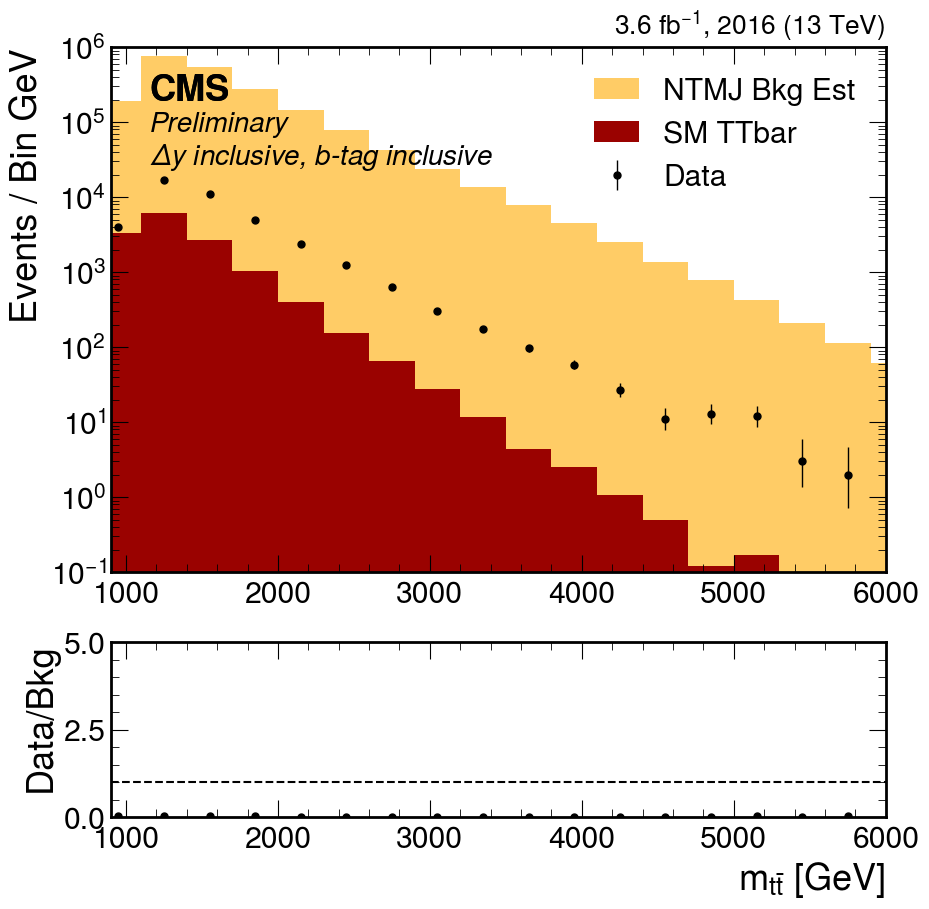

In [66]:

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])



# hrpf = functions.getHist2('ttbarmass', 'JetHT', IOV,
#          sum_axes=['anacat'],
#          integrate_axes={'systematic':'nominal', 'anacat':antitag_cats},
#          tag = '_bkgest'
#         )


fsigB = util.load('../outputs/AC/JetHT_2017B_bkgest.coffea')
fsigC = util.load('../outputs/AC/JetHT_2017C_bkgest.coffea')
fsigD = util.load('../outputs/AC/JetHT_2017D_bkgest.coffea')
fsigE = util.load('../outputs/AC/JetHT_2017E_bkgest.coffea')
fsigF = util.load('../outputs/AC/JetHT_2017F_bkgest.coffea')


hsigB = fsigB['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
hsigC = fsigC['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
hsigD = fsigD['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
hsigE = fsigE['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
hsigF = fsigF['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]

hntmjB = fsigB['ttbarmass'][{'systematic':'nominal', 'anacat':antitag_cats}][{'anacat':sum}]
hntmjC = fsigC['ttbarmass'][{'systematic':'nominal', 'anacat':antitag_cats}][{'anacat':sum}]
hntmjD = fsigD['ttbarmass'][{'systematic':'nominal', 'anacat':antitag_cats}][{'anacat':sum}]
hntmjE = fsigE['ttbarmass'][{'systematic':'nominal', 'anacat':antitag_cats}][{'anacat':sum}]
hntmjF = fsigF['ttbarmass'][{'systematic':'nominal', 'anacat':antitag_cats}][{'anacat':sum}]

hsig = hsigB + hsigC + hsigD + hsigE + hsigF
hntmj = (hntmjB + hntmjC + hntmjD + hntmjE + hntmjF)/3


fsig2 = util.load('../outputs/AC/scale/JetHT_2017.coffea')

fttbar = util.load('../outputs/AC/scale/TTbar_2017.coffea')

hsig = fsig2['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
# hntmj = fsig['ttbarmass'][{'systematic':'nominal', 'anacat':pretag_cats}][{'anacat':sum}]
httbar = fttbar['ttbarmass'][{'systematic':'nominal', 'anacat':signal_cats}][{'anacat':sum}]
hbkg = hntmj + httbar

# httbar = functions.getHist2('ttbarmass', 'TTbar', IOV,
#          sum_axes=['anacat'],
#          integrate_axes={'systematic':'nominal', 'anacat':signal_cats},        
#         )

# httbar2 = functions.getHist2('ttbarmass', 'TTbar', IOV,
#          sum_axes=['anacat'],
#          integrate_axes={'systematic':'nominal', 'anacat':antitag_cats},        
#         )



# hsig = functions.getHist2('ttbarmass', 'JetHT', IOV,
#          sum_axes=['anacat'],
#          integrate_axes={'systematic':'nominal', 'anacat':signal_cats}        
#         )


# hUnc = functions.getHist2('ttbarmass', 'JetHT', IOV,
#          sum_axes=['anacat'],
#          integrate_axes={'anacat':antitag_cats},
#          tag = '_bkgest')


# hbkg = (-10) * hrpf + httbar2


# hUp, hDn = getUncertainy(hbkg, (-1)*hUnc)

text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hsig, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='#ffcc66', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)

# height = hUp.values() + hDn.values()
# bottom = hbkg.values() - hDn.values()
# edges  = hbkg.axes['ttbarmass'].edges


# ax1.bar(x = edges[:-1],
#            height=height,
#            bottom=bottom,
#            width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
#            linewidth=0, facecolor='none', alpha=0.7,
#            zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
# ratioUp = hUp.values() / hbkg.values()
# ratioDn = hUp.values() / hbkg.values()


# ax2.bar(x = edges[:-1],
#            height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
#            bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
#            width = np.diff(edges), align='edge', edgecolor='gray',
#            linewidth=0, facecolor='gray', alpha=0.3,
#            zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0, 5)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e6)
ax1.set_xlim(900,6000)
ax2.set_xlim(900,6000)
ax1.set_xlabel('')








[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fbbbf5f9910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

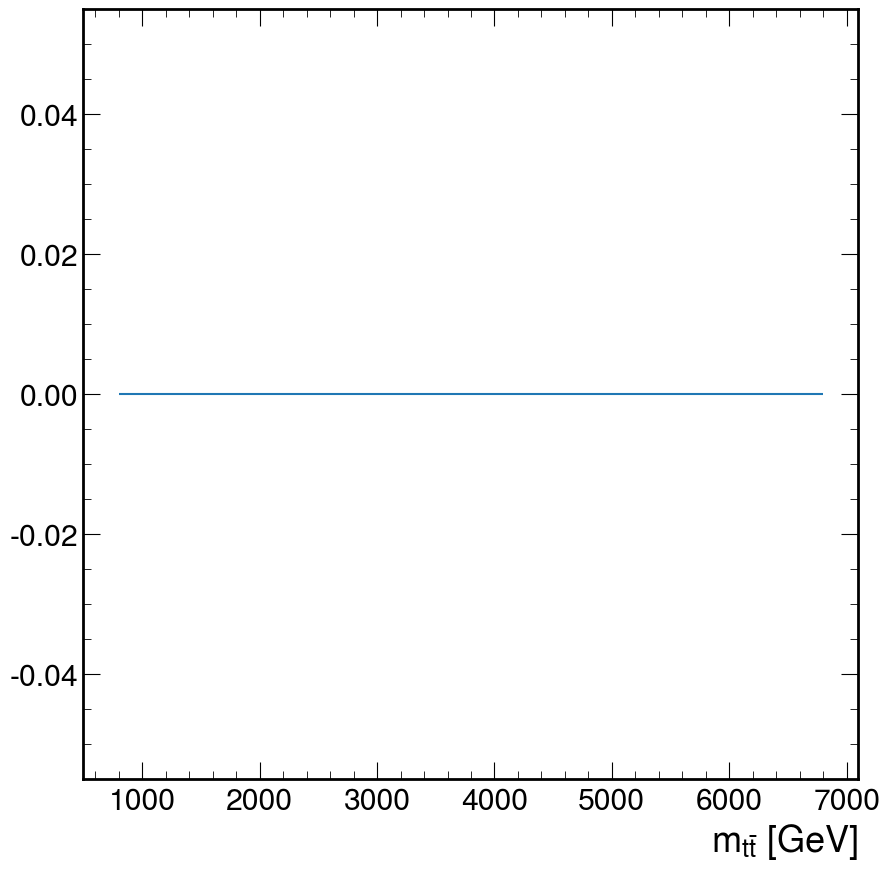

In [58]:
hsigC.plot()

In [59]:
f = util.load('../outputs/AC/JetHT_2017B_bkgest.coffea')

In [64]:
f['ttbarmass'][{'systematic':'nominal', 'anacat':antitag_cats}]

Hist(
  IntCategory([0, 1, 2, 3, 4, 5], name='anacat', label='Analysis Category'),
  Regular(20, 800, 6800, name='ttbarmass', label='$m_{t\\bar{t}}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=754032, variance=754032) (WeightedSum(value=754156, variance=754156) with flow)

## --- work in progress --- ##

## QCD Closure Test 
### using bkgest from ttbarprocessor.py

In [ ]:
IOV = '2017'

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

hrpf = functions.getHist2('ttbarmass', 'QCD', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':antitag_cats},
         tag = '_bkgest'

        )

hsig = functions.getHist2('ttbarmass', 'QCD', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},
         tag = ''
        )

# 2D histogram with all uncertainties for getting background uncertainty
hUnc = functions.getHist2('ttbarmass', 'QCD', IOV,
         sum_axes=['anacat'],
         integrate_axes={'anacat':antitag_cats},
         tag = '_bkgest')

hbkg = (-10) * hrpf

hUp, hDn = getUncertainy(hbkg, -1 * hUnc)


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all','').replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hsig, histtype='errorbar', color='black', label='QCD SR', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='QCD Bkg Est', ax=ax1)
herr = np.sqrt(hbkg.variances())

height = hUp.values() + hDn.values()
bottom = hbkg.values() - hDn.values()
edges  = hbkg.axes['ttbarmass'].edges


ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
ratioUp = hUp.values() / hbkg.values()
ratioDn = hUp.values() / hbkg.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')

hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(-10,10)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e13)
ax1.set_xlim(900,6000)
ax2.set_xlim(900,6000)
ax1.set_xlabel('')

## Kinematics

In [ ]:

IOV = '2017'



fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

histname = 'jeteta'


httbar = functions.getHist2(histname, 'TTbar', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},        
        )

hqcd = functions.getHist2(histname, 'QCD', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats},        
        )


hsig = functions.getHist2(histname, 'JetHT', IOV,
         sum_axes=['anacat'],
         integrate_axes={'systematic':'nominal', 'anacat':signal_cats}        
        )




lumifactor = 1.0


hbkg = hqcd + httbar


hUnc = functions.getHist2(histname, 'TTbar', IOV,
         sum_axes=['anacat'],
         integrate_axes={'anacat':signal_cats},        
        )




hUp, hDn = getUncertainy(hbkg, hUnc)

text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b-tag inclusive'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(functions.lumi[IOV]*lumifactor/1000), year=IOV.replace('all',''), loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

hep.histplot(hsig, histtype='errorbar', color='black', label='Data', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='#ffcc66', label='SM QCD', ax=ax1, alpha=1.0)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='SM TTbar', ax=ax1)

height = hUp.values() + hDn.values()
bottom = hbkg.values() - hDn.values()
edges  = hbkg.axes[histname].edges


ax1.bar(x = edges[:-1],
           height=height,
           bottom=bottom,
           width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
           linewidth=0, facecolor='none', alpha=0.7,
           zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
ratioUp = hUp.values() / hbkg.values()
ratioDn = hDn.values() / hbkg.values()


ax2.bar(x = edges[:-1],
           height=(np.ones_like(ratio_plot.values()) + ratioUp + ratioDn),
           bottom=(np.ones_like(ratio_plot.values()) - ratioDn),
           width = np.diff(edges), align='edge', edgecolor='gray',
           linewidth=0, facecolor='gray', alpha=0.3,
           zorder=10, label='Unc.')


ratio_plot =  hsig / hbkg.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0, 5)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel(f'Events / Bin GeV'.replace('j',''))
ax1.set_yscale('log')
# ax1.set_ylim(1e-1, 1e12)
# ax1.set_xlim(900,6000)
# ax2.set_xlim(900,6000)
ax1.set_xlabel('')








In [ ]:
hqcd.plot()

In [ ]:
f = util.load('../outputs/scale/RSGluon1000_2017.coffea')

In [ ]:
np.sum(f['ttbarmass'][{'systematic':'nominal', 'anacat':label_to_int['2t2bcen']}].values())

In [ ]:
np.sum(f['ttbarmass'][{'systematic':'nominal', 'anacat':label_to_int['2t2bfwd']}].values())

In [ ]:
36/201